# Analysis for ORLR workshop, NeurIPS 2020

In [53]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as distance
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring
import random

import pickle

### Load dataframes

In [42]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/df_block.csv')
df_chat = pd.read_csv('../results/csv/df_chat.csv')
df_exit = pd.read_csv('../results/csv/df_exit.csv')
df_trial = pd.read_csv('../results/csv/df_trial.csv')

### Apply exclusion criteria

In [43]:
# How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [44]:
includedGames = list(df75.reset_index().gameid)

In [45]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

#### Get trial sequences

In [52]:
df_trial.loc[:,'target'] = df_trial['leftTarget'] + df_trial['rightTarget']
list(df_trial[~(df_trial.practice)].groupby('gameid')['target'].apply(list))

[['LPi',
  'LC',
  'CPi',
  'PiC',
  'CL',
  'PiL',
  'LC',
  'CPi',
  'LPi',
  'CL',
  'PiC',
  'PiL'],
 ['LC',
  'LPi',
  'CPi',
  'CL',
  'PiC',
  'PiL',
  'LC',
  'CPi',
  'LPi',
  'PiL',
  'CL',
  'PiC'],
 ['LPi',
  'LC',
  'CPi',
  'PiL',
  'CL',
  'PiC',
  'LC',
  'CPi',
  'LPi',
  'CL',
  'PiC',
  'PiL'],
 ['CPi',
  'LC',
  'LPi',
  'CL',
  'PiL',
  'PiC',
  'LPi',
  'CPi',
  'LC',
  'PiC',
  'CL',
  'PiL'],
 ['CPi',
  'LPi',
  'LC',
  'CL',
  'PiL',
  'PiC',
  'LC',
  'LPi',
  'CPi',
  'PiC',
  'PiL',
  'CL'],
 ['CPi',
  'LC',
  'LPi',
  'PiC',
  'CL',
  'PiL',
  'LC',
  'LPi',
  'CPi',
  'CL',
  'PiC',
  'PiL'],
 ['LPi',
  'LC',
  'CPi',
  'PiC',
  'CL',
  'PiL',
  'LPi',
  'CPi',
  'LC',
  'CL',
  'PiC',
  'PiL'],
 ['LC',
  'CPi',
  'LPi',
  'PiC',
  'PiL',
  'CL',
  'LPi',
  'LC',
  'CPi',
  'PiC',
  'PiL',
  'CL'],
 ['LPi',
  'CPi',
  'LC',
  'CL',
  'PiC',
  'PiL',
  'LC',
  'LPi',
  'CPi',
  'PiC',
  'PiL',
  'CL'],
 ['CPi',
  'LPi',
  'LC',
  'CL',
  'PiL',
  'PiC',
  '

## Task performance

### Accuracy

In [7]:
# accuracy across trials
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='x')
# sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='trialScore', hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

ValueError: Could not interpret input 'x'

<Figure size 720x432 with 0 Axes>

### Timing

In [8]:
# # Wrangle timing dataframes

# # Find the latest time that a block was placed in each trial.
# # This signifies the end of a trial (i.e. upper bound on total trial time)
# df_trial_time = df_block[~df_block.practice].groupby(['gameid','trialNum'])\
#                 ['timeElapsedInTrial'].max().reset_index()
# df_trial_time = df_trial_time.rename(columns = {'timeElapsedInTrial':'time_final_block'})

# # Grab the duration of the Architect's turn
# chat_times = df_chat[~df_chat.practice].groupby(['gameid','trialNum'])\
# ['timeElapsedInTurn'].sum().reset_index()

# # total time to place blocks (by taking summing maximum block placement time for each turn)
# total_block_times = df_block[(~df_block.practice)].groupby(['gameid','trialNum','turnNum'])\
#                     ['timeElapsedInTurn'].max()\
#                     .groupby(['gameid','trialNum']).sum().reset_index()

# # # time from trial_start to final block placed in turn, summed across the trial
# df_trial_time['total_block_duration'] = total_block_times['timeElapsedInTurn'] 

# # time from trial_start to chat message sent, summed across the trial
# df_trial_time['total_chat_duration'] = chat_times['timeElapsedInTurn']

# # # sum of block placement and chat time in a trial
# df_trial_time['total_duration'] = df_trial_time['total_chat_duration'] + df_trial_time['total_block_duration']

# # # differnce between final block placement time and total chat plus block placement time.
# # # i.e. the total extra time in a trial, mainly consisting of time to press done button
# df_trial_time['diff'] = df_trial_time['time_final_block'] - df_trial_time['total_duration']

# # in addition, add a total_turn_duration- 
# #  the time between this turn start and the next turn start (or final block placement)
# #  as an estimate for when the Done button is pressed.
# # didn't have the data for this in pilot3- we are now saving turnStartTime

# # re-add trial info to trial df
# df_trial = df_trial.merge(df_trial_time, how='left', on=['gameid','trialNum'])

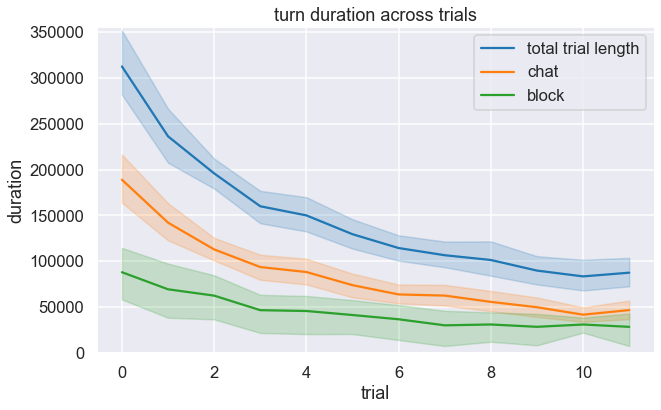

In [9]:
# total trial time across trials

g = plt.figure(figsize=(10,6))
ax1 = sns.lineplot(data=df_trial, x='trialNum', y='time_final_block', label='total trial length')
ax2 = sns.lineplot(data=df_trial, x='trialNum', y='total_chat_duration', label='chat')
ax3 = sns.lineplot(data=df_trial, x='trialNum', y='total_block_duration', label='block')

plt.ylabel('duration')
plt.xlabel('trial')
plt.ylim((0,355000))
plt.title('turn duration across trials')
plt.legend()

Text(0.5, 1.0, 'trial duration (final block placement time) across trials')

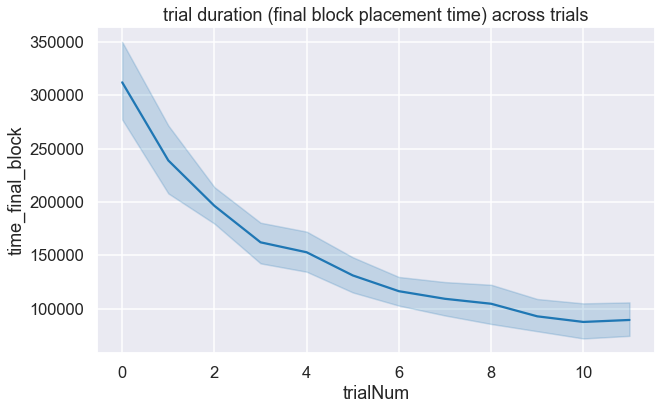

In [10]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='time_final_block')
# plt.ylim((0,350000))
plt.title('trial duration (final block placement time) across trials')

Text(0.5, 1.0, 'total chat duration across trials')

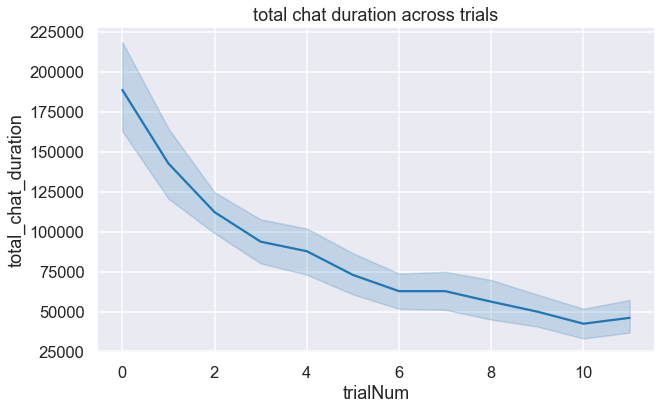

In [11]:
# total chat duration (architect turn-time) across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='total_chat_duration')
# plt.ylim((0,350000))
plt.title('total chat duration across trials')

Text(0.5, 1.0, 'total block duration across trials')

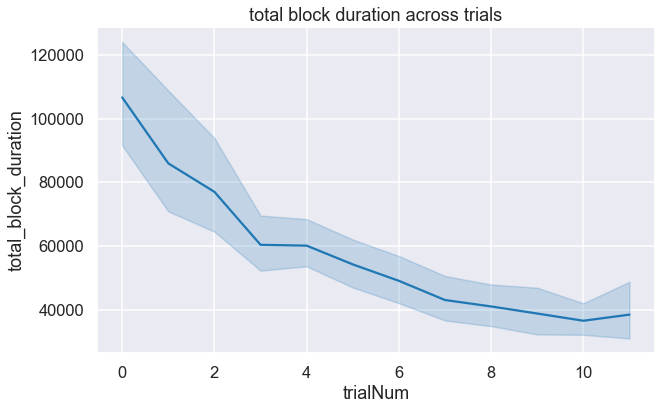

In [12]:
# total block placement duration (builder turn-time, not inluding no-block turns), across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='total_block_duration')
# plt.ylim((0,350000))
plt.title('total block duration across trials')

Text(0.5, 1.0, 'difference between total block time and final block times')

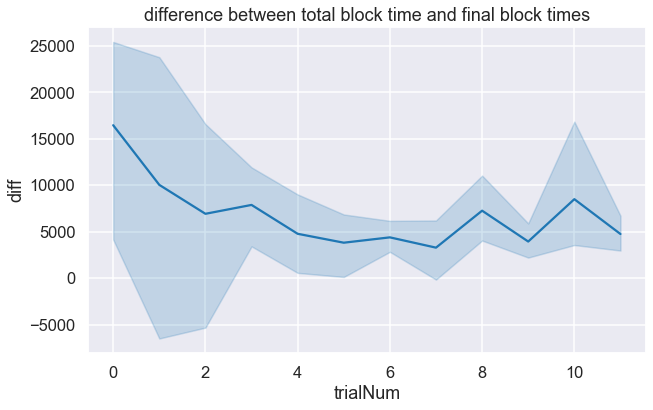

In [13]:
# total block placement duration (builder turn-time, not inluding no-block turns), across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='diff')
# plt.ylim((0,350000))
plt.title('difference between total block time and final block times')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## NLP

### Efficiency of instructions

#### Across trials

Text(0.5, 1.0, 'total words across trials')

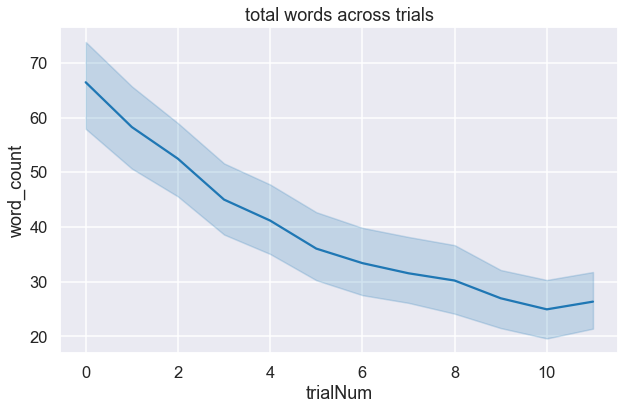

In [14]:
# word count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='word_count')
#              , hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total words across trials')

Text(0.5, 1.0, 'total characters across trials')

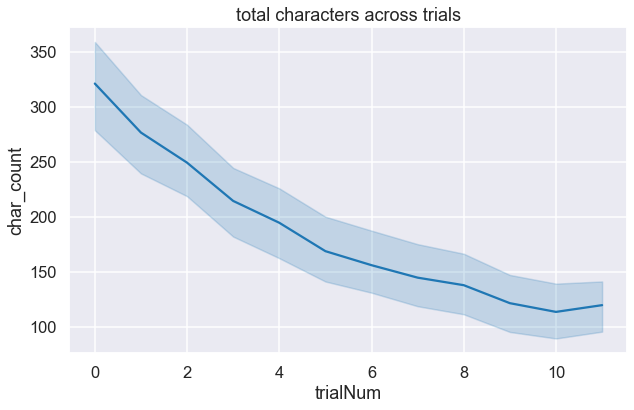

In [15]:
# char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='char_count')
             #, hue='gameid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total characters across trials')

#### Across repetitions of scenes (sides of towers can switch)

In [16]:
rep_sums = df_chat[~df_chat.practice].groupby(['gameid','repNum']).sum().reset_index()
trial_counts = df_chat.groupby(['gameid','trialNum']).count().reset_index()

Text(0.5, 1.0, 'total words across reps')

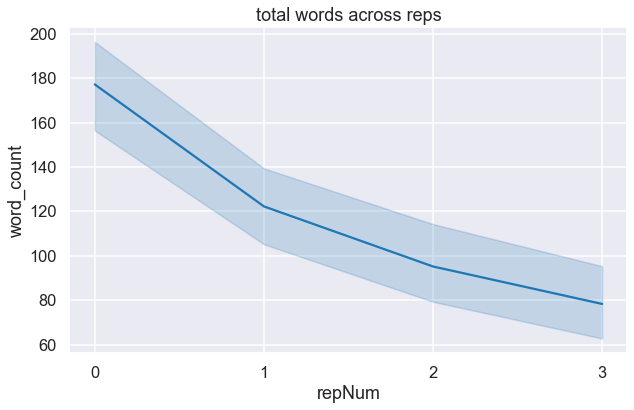

In [17]:
# word count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='word_count')
plt.title('total words across reps')

Text(0.5, 1.0, 'total characters across reps')

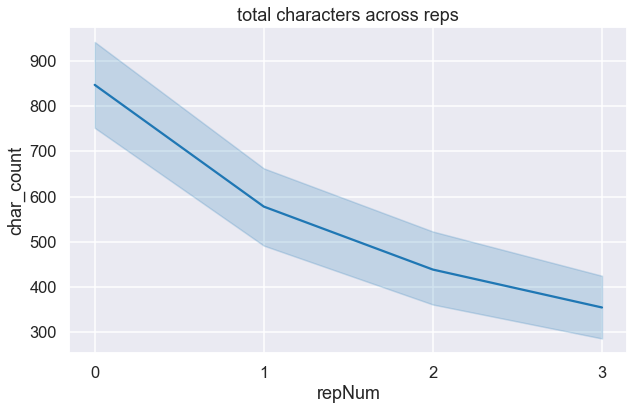

In [18]:
# char count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='char_count')
plt.title('total characters across reps')

### Conventions

### Compositional abstractions

#### 3.5: Convergence/ divergence analysis

Use function that takes a distance matrix and return a variance. 
Wasserstein distance between every pair WITHIN a rep
Take a random 49 participants to get a new distance matrix. (Do this 1000 times for 95% CIs)
Stat: how many had a difference in the opposite direction.
Error bars: 1.96\*SE of resample distribution (1000)

We talked about doing ‘Jackknife’ resampling (deterministic leave-one-out for all ppts, for every sample find difference- difference distribution.) plus adjusting for smaller sample size

The point of this analysis is to show that people end up using more similar words to each other than they start with. I'm currently concerned that if all people use fewer words at the end, then it might reduce the distance between them all.


In [19]:
df_refexp_unprocessed = pd.read_csv('../results/csv/JJ_content.csv')
df_refexp_unprocessed

,gameid,leftTarget,rightTarget,trialNum,turnNum,repNum,message,# @ block-level,# @ tower-level,# @ scene-level,phrases,phrases.1,content
0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,4,0,Now place a blue block on top of that that lin...,1,0,0,a blue block,a blue block,a blue block a blue block
1,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,6,0,"remove that last blue block, place it on top o...",1,0,0,that last blue block,last blue block,that last blue block last blue block
2,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,8,0,place a red block on the second grid from the ...,1,0,0,a red block,a red block,a red block a red block
3,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,10,0,now place another red block three more space t...,1,0,0,another red block,another red block,another red block another red block
4,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,12,0,place two blue blocks next to each other conne...,2,0,0,two blue blocks,two blue blocks,two blue blocks two blue blocks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,C,Pi,7,0,2,"left- very tall skinny C, right - arch",0,2,0,"very tall skinny C, arch","very tall skinny C, arch","very tall skinny C, arch very tall skinny C, arch"
2136,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,L,C,8,0,2,"left- large L, right - very tall skinny C",0,2,0,"large L, very tall skinny C","large L, very tall skinny C","large L, very tall skinny C large L, very tall..."
2137,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,Pi,C,9,0,3,"left- arch, right - very tall skinny C",0,2,0,"arch, very tall skinny C","arch, very tall skinny C","arch, very tall skinny C arch, very tall skinny C"
2138,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,Pi,L,10,0,3,"you are rockin this! Left- arch, right- large L",0,2,0,"arch, large L","arch, large L","arch, large L arch, large L"


In [20]:
df_refexp_unprocessed = pd.read_csv('../results/csv/JJ_content.csv')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.lower()
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'~', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'\(', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'\)', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'\,', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r"\'", '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r"\:", '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r"\;", '')

In [21]:
# Get word frequency distributions for all ppts
df_refexp = df_refexp_unprocessed.groupby(['gameid','repNum'])['content'].apply(lambda x: ' '.join(x)).reset_index()
df_refexp['word_freq'] = df_refexp['content'].apply(lambda x: Counter(x.split()))
df_refexp.head()

,gameid,repNum,content,word_freq
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks two blue two red block two red...,"{'two': 15, 'blue': 17, 'blocks': 4, 'red': 15..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,same exact construction the same exact constru...,"{'same': 2, 'exact': 2, 'construction': 2, 'th..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two blue blocks two blue two red blocks two re...,"{'two': 14, 'blue': 16, 'blocks': 4, 'red': 11..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block two red blue two red one blue b...,"{'one': 9, 'blue': 16, 'block': 8, 'two': 10, ..."
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,blue blue blue blue blue blue red red red red ...,"{'blue': 22, 'red': 24, 'another': 1, 'last': ..."


In [22]:
# create support
split_words = df_refexp['content'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [23]:
def jsdiv(P, Q):
    """Compute the Jensen-Shannon divergence between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    def _kldiv(A, B):
        return np.sum([v for v in A * np.log2(A/B) if not np.isnan(v)])

    P = np.array(P)
    Q = np.array(Q)

    M = 0.5 * (P + Q)

    return 0.5 * (_kldiv(P, M) +_kldiv(Q, M))

In [893]:
df_refexp['word_pdist'] = df_refexp.apply(get_pdist, axis = 1)
df_refexp['word_pdist_numeric'] = df_refexp['word_pdist'].apply(lambda dist: list(dist.values()))

In [25]:
# Take Wasserstein distance between every pair within each rep (save to table)

reps = [0,3]
dyads = list(df_refexp['gameid'].unique())

empirical_distances = np.zeros((len(reps),len(dyads),len(dyads)))

for r, rep in enumerate(reps):
    for i, dyad_i in enumerate(dyads):
        dyad_i_pdist = df_refexp[(df_refexp.repNum==rep) & (df_refexp.gameid==dyad_i)]['word_pdist_numeric'].iloc[0]
        for j, dyad_j in enumerate(dyads):
            dyad_j_pdist = df_refexp[(df_refexp.repNum==rep) & (df_refexp.gameid==dyad_j)]['word_pdist_numeric'].iloc[0]
            empirical_distances[r,i,j] = jsdiv(dyad_i_pdist, dyad_j_pdist)
            
            

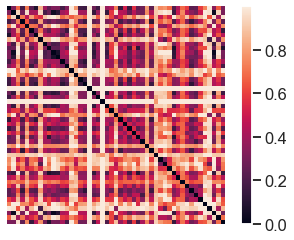

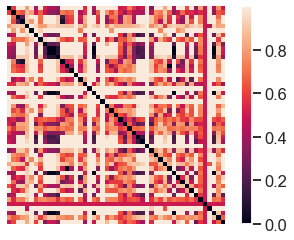

In [26]:
# show distances between dyads in first and final rep- looks like larger differences in the final rep (higher divergence)

fig, ax = plt.subplots()
ax.axis('off')
im = ax.imshow(empirical_distances[0])
fig.colorbar(im)

fig, ax = plt.subplots()
ax.axis('off')
im = ax.imshow(empirical_distances[1])
fig.colorbar(im)

### Inspect popularity of referring expressions in rep

In [498]:
stds = {}

for r in [0,3]:
    stds[r] = {}
    w_probs = {}

    for w in all_words:
        w_probs[w] = list(df_refexp[(df_refexp.repNum==r)]['word_pdist'].apply(lambda probs: probs[w]))

    for w in all_words:    
        stds[r][w] = np.std(w_probs[w])
        
    stds[r] = {k: v for k, v in sorted(stds[r].items(), key=lambda item: item[1])}

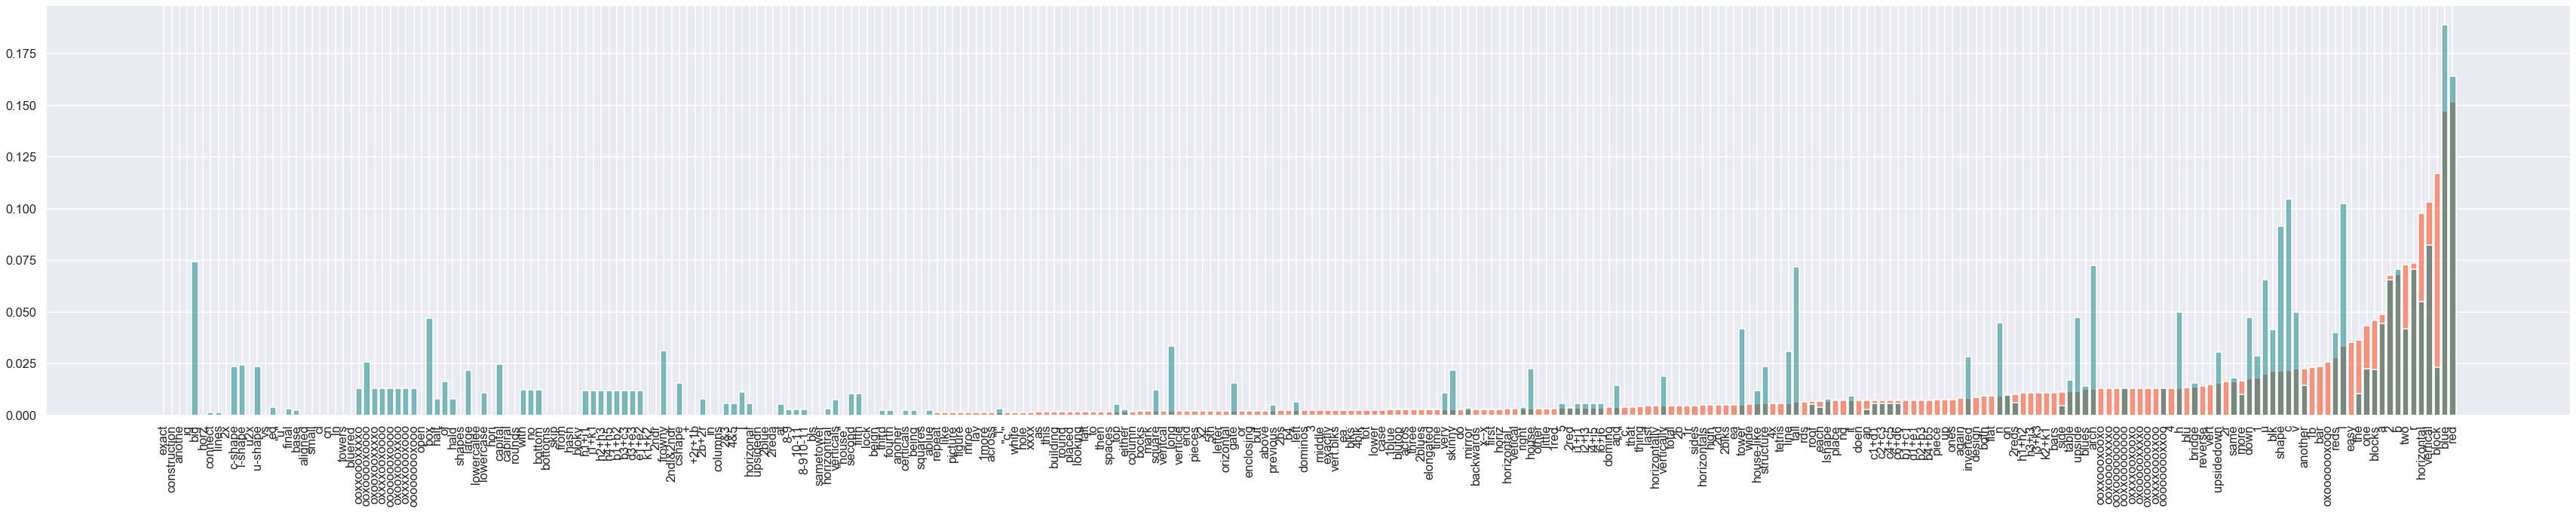

In [499]:
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(111)
ax.bar(x = list(stds[0].keys()), height= stds[0].values(), fc=(1, 0.2, 0, 0.5))
ax.bar(x = list(stds[0].keys()), height= [stds[3][w] for w in list(stds[0].keys())], fc=(0, 0.5, 0.5, 0.5))
_ = plt.xticks(rotation='vertical')
plt.savefig('words.pdf')

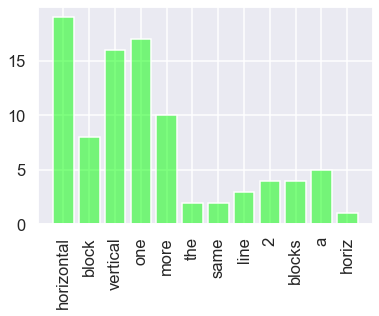

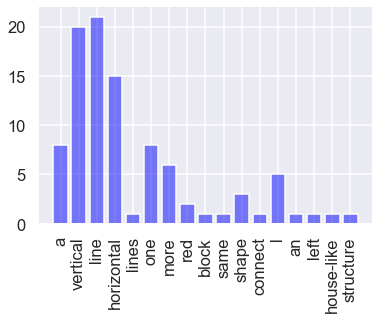

In [501]:
# inspect words from one dyay

fig = plt.figure()
ax = fig.add_subplot(111)
dyad_num = 4

counts = df_refexp[(df_refexp.repNum==0) & (df_refexp.gameid==dyads[dyad_num])]['word_freq'].iloc[0]
ax.bar(x = list(counts.keys()), height= list(counts.values()), fc=(0, 1, 0, 0.5))
_ = plt.xticks(rotation='vertical')

fig = plt.figure()
ax = fig.add_subplot(111)

counts = df_refexp[(df_refexp.repNum==3) & (df_refexp.gameid==dyads[dyad_num])]['word_freq'].iloc[0]
ax.bar(x = list(counts.keys()), height= list(counts.values()), fc=(0, 0, 1, 0.5))
_ = plt.xticks(rotation='vertical')

### assess difference in variability from first to final rep

In [1]:
# Bootstrap sample 49 ppts and get values from above dataframe to create a new distance matrix

n = df_refexp['gameid'].nunique()
n_indices = list(range(0,n))
ppts = df_refexp['gameid'].unique()
nIters = 1000

differences = np.zeros(nIters)
rep_1_var = np.zeros(nIters)
rep_4_var = np.zeros(nIters)

seed = 0
for i in range(0,nIters): #1000 times
        
    seed += 1
#     rep1_random_state = seed # Use same sample across reps
#     rep3_random_state = seed # Use same sample across reps

    random.seed(seed)
    ppt_sample = [random.choice(n_indices, ) for _ in n_indices]
    rep1_distances = np.zeros((n,n))
    rep4_distances = np.zeros((n,n))
    
    for a, ppt_a in enumerate(ppt_sample):
        for b, ppt_b in enumerate(ppt_sample):
            rep1_distances[a,b] = empirical_distances[0][ppt_a,ppt_b]
            rep4_distances[a,b] = empirical_distances[1][ppt_a,ppt_b]

    
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep1_distances))
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep4_distances))
    
    rep1_sum_sq_diffs = np.sum(np.triu(np.square(rep1_distances)))
    rep_1_var[i] = rep1_sum_sq_diffs/(n**2)
    
    rep4_sum_sq_diffs = np.sum(np.triu(np.square(rep4_distances)))
    rep_4_var[i] = rep4_sum_sq_diffs/(n**2)
    
    differences[i] = rep_4_var[i] - rep_1_var[i]

plt.hist(differences)


NameError: name 'df_refexp' is not defined

In [504]:
(sum(differences < 0)/nIters)*2

0.004

In [748]:
np.quantile(differences, [0.05, 0.95])

array([0.0404929 , 0.11800891])

In [750]:
differences.mean()

0.0798783845081796

In [744]:
stats.CI(rep_1_var)

AttributeError: module 'scipy.stats' has no attribute 'CI'

In [ ]:
# For error bars, calculate 1.96*SE of distribution of distances, and +/-  to mean




In [505]:
df_refexp[(df_refexp.repNum==rep) & (df_refexp.gameid==dyad_i)]['word_freq']

195    {'a': 8, 'blue': 15, 'two': 12, 'reds': 8, 'ab...
Name: word_freq, dtype: object

In [541]:

df_refexp_unprocessed.groupby(['repNum'])['content']\
    .apply(lambda x: ' '.join(x)).reset_index()['content'].apply(lambda words: set(words.split()))


0    {d1+e1, "c", b2+b3, oxxxxooxooxo, other, case,...
1    {oxxxxoooxooo, other, 2reds, vs, blu, box, lin...
2    {d1+e1, "c", b2+b3, oxxxxooxooxo, fourth, lock...
3    {oxxxxoooxooo, fourth, 2reds, 5, box, line, j1...
Name: content, dtype: object

In [532]:
# how many unique tokens are being used in the first rep vs. last rep?
df_refexp_unprocessed.groupby(['repNum'])['content']\
            .apply(lambda x: ' '.join(x)).reset_index()['content'].apply(lambda words: len(set(words.split())))

0    195
1    152
2    150
3    129
Name: content, dtype: int64

(array([ 13.,  30.,  85., 148., 248., 219., 189.,  46.,  19.,   3.]),
 array([-8.79591837, -8.10612245, -7.41632653, -6.72653061, -6.03673469,
        -5.34693878, -4.65714286, -3.96734694, -3.27755102, -2.5877551 ,
        -1.89795918]),
 <a list of 10 Patch objects>)

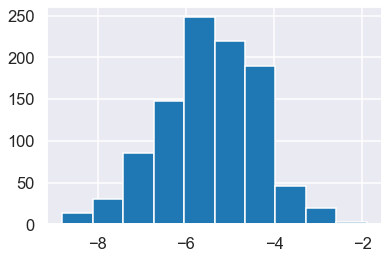

In [540]:
# Bootstrap sample 49 ppts and get values from above dataframe to create a new distance matrix

n = df_refexp['gameid'].nunique()
n_indices = list(range(0,n))
dyads = df_refexp['gameid'].unique()
nIters = 1000

n_tokens = pd.DataFrame()

seed = 0
for i in range(0,nIters): #1000 times
        
    seed += 1
#     rep1_random_state = seed # Use same sample across reps
#     rep3_random_state = seed # Use same sample across reps

    np.random.seed(seed)
    dyad_sample = [np.random.choice(n_indices, ) for _ in n_indices]
    
    for d, dyad in enumerate(dyad_sample):
        dyad_tokens = df_refexp_unprocessed[df_refexp_unprocessed.gameid==dyads[dyad]].groupby(['repNum'])['content']\
            .apply(lambda x: ' '.join(x)).reset_index()['content'].apply(lambda words: len(set(words.split())))
    
        dyad_tokens['iter'] = i
        dyad_tokens['dyad'] = d
        n_tokens = n_tokens.append(dyad_tokens)
        
        
n_tokens['difference'] = n_tokens[3] - n_tokens[0]

#n_tokens.groupby('iter').mean()

#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep1_distances))
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep4_distances))
    
#     rep1_sum_sq_diffs = np.sum(np.triu(np.square(rep1_distances)))
#     rep_1_var[i] = rep1_sum_sq_diffs/(n**2)
    
#     rep4_sum_sq_diffs = np.sum(np.triu(np.square(rep4_distances)))
#     rep_4_var[i] = rep4_sum_sq_diffs/(n**2)
    
#     differences[i] = rep_4_var[i] - rep_1_var[i]

plt.hist(n_tokens.groupby('iter').mean()['difference'])


In [543]:
(sum(n_tokens.groupby('iter').mean()['difference']>0)/nIters)*2

0.0

In [551]:
n_tokens.groupby('iter').mean().iloc[:,0:4]

,0,1,2,3
iter,,,,
0.0,12.102041,10.959184,8.591837,7.000000
1.0,13.673469,11.816327,9.265306,7.795918
2.0,12.122449,10.653061,8.326531,6.244898
3.0,12.836735,10.979592,8.163265,6.530612
4.0,13.510204,12.040816,9.204082,7.306122
...,...,...,...,...
995.0,13.428571,11.836735,8.204082,6.653061
996.0,12.979592,10.938776,7.408163,5.612245
997.0,12.020408,11.183673,8.979592,7.224490


### Look at number of dyads using these referring expressions 

In [28]:
# dataframe from above
df_refexp

,gameid,repNum,content,word_freq,word_pdist,word_pdist_numeric
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks two blue two red block two red...,"{'two': 15, 'blue': 17, 'blocks': 4, 'red': 15...","{'two': 0.22727272727272727, 'blue': 0.2575757...","[0.22727272727272727, 0.25757575757575757, 0.0..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,same exact construction the same exact constru...,"{'same': 2, 'exact': 2, 'construction': 2, 'th...","{'two': 0.15384615384615385, 'blue': 0.1794871...","[0.15384615384615385, 0.1794871794871795, 0.07..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two blue blocks two blue two red blocks two re...,"{'two': 14, 'blue': 16, 'blocks': 4, 'red': 11...","{'two': 0.1917808219178082, 'blue': 0.21917808...","[0.1917808219178082, 0.2191780821917808, 0.054..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block two red blue two red one blue b...,"{'one': 9, 'blue': 16, 'block': 8, 'two': 10, ...","{'two': 0.1388888888888889, 'blue': 0.22222222...","[0.1388888888888889, 0.2222222222222222, 0.055..."
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,blue blue blue blue blue blue red red red red ...,"{'blue': 22, 'red': 24, 'another': 1, 'last': ...","{'two': 1e-09, 'blue': 0.44, 'blocks': 0.02, '...","[1e-09, 0.44, 0.02, 0.48, 1e-09, 1e-09, 1e-09,..."
...,...,...,...,...,...,...
191,9727-37a58c13-7178-412c-88d0-6b8841439106,3,another house shape certicals second and fifth...,"{'another': 1, 'house': 4, 'shape': 3, 'certic...","{'two': 0.03636363636363636, 'blue': 0.0363636...","[0.03636363636363636, 0.03636363636363636, 1e-..."
192,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,0,a blue block blue a blue block blue a red bloc...,"{'a': 21, 'blue': 24, 'block': 24, 'red': 24, ...","{'two': 1e-09, 'blue': 0.25, 'blocks': 1e-09, ...","[1e-09, 0.25, 1e-09, 0.25, 0.25, 1e-09, 1e-09,..."
193,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,1,a red block red a red block red blue blocks bl...,"{'a': 10, 'red': 16, 'block': 13, 'blue': 18, ...","{'two': 0.125, 'blue': 0.225, 'blocks': 0.1125...","[0.125, 0.225, 0.1125, 0.2, 0.1625, 1e-09, 1e-..."
194,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,a blue block blue another blue block blue two ...,"{'a': 7, 'blue': 18, 'block': 7, 'another': 2,...","{'two': 0.17391304347826086, 'blue': 0.2608695...","[0.17391304347826086, 0.2608695652173913, 0.04..."


In [29]:
df_all_words = df_refexp[['gameid', 'repNum', 'content']]

In [30]:
for w in all_words:
    df_all_words[w] = df_all_words['content'].apply(lambda row: int(w in row.split()))
    
df_all_words_reps = df_all_words.groupby('repNum').agg(sum)

df_all_words_reps = df_all_words_reps.sort_values(by = 0, axis = 1)

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


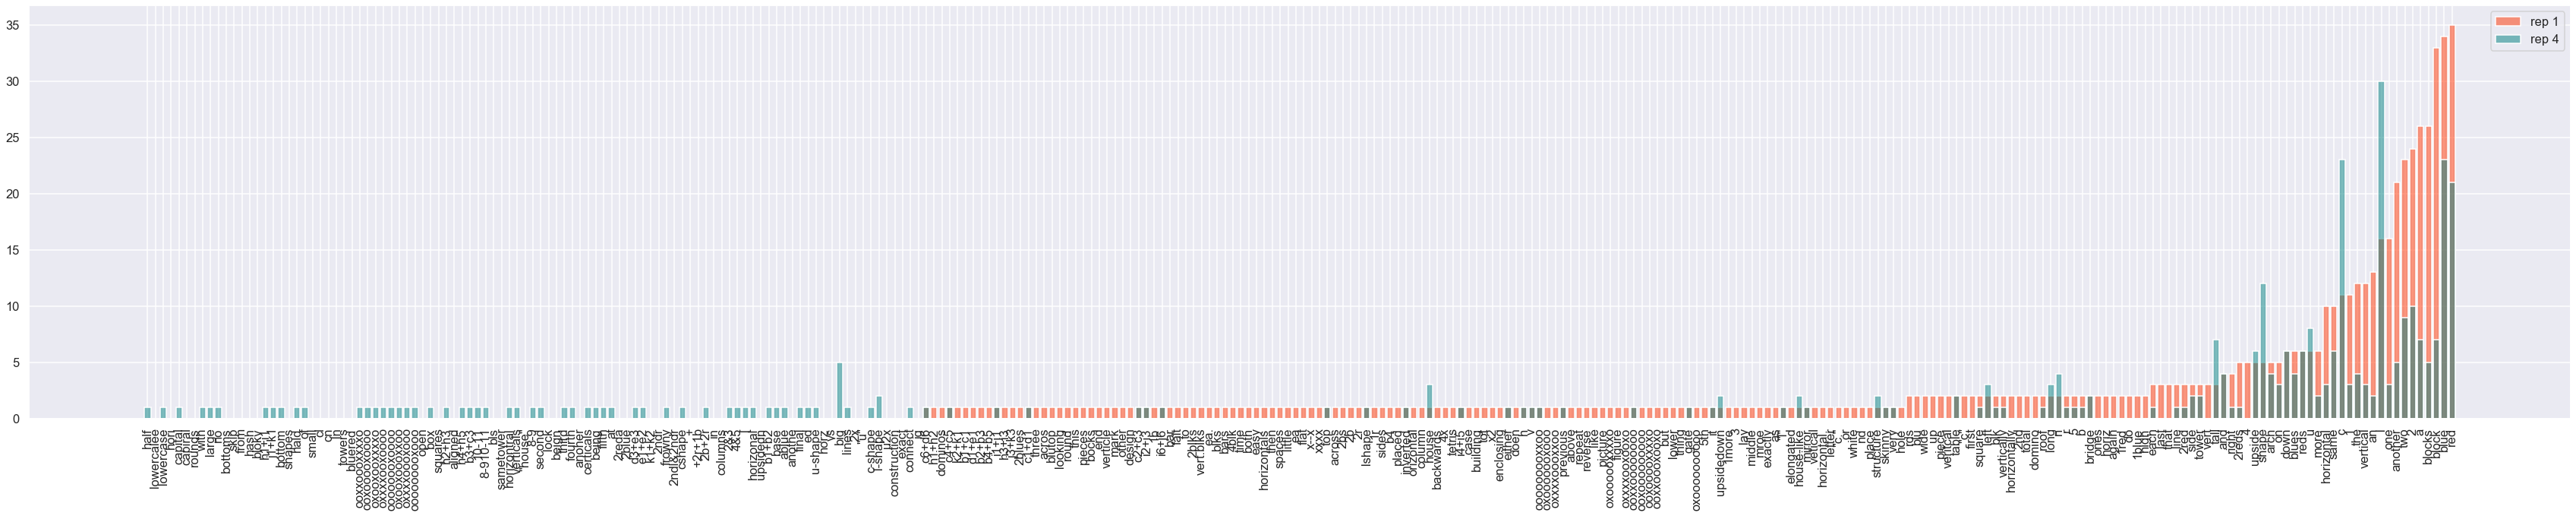

In [50]:
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(111)
ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[0,:], fc=(1, 0.2, 0, 0.5))
# ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[1,:], fc=(1, 0, 0.3, 0.5))
# ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[2,:], fc=(1, 0.8, 0.8, 0.5))
ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[3,:], fc=(0, 0.5, 0.5, 0.5))
# plt.legend(['rep 1', 'rep 2', 'rep 3', 'rep 4'])
plt.legend(['rep 1', 'rep 4'])
_ = plt.xticks(rotation='vertical')
plt.savefig('words_by_dyads_rep1.pdf')

## Clustering analysis

Are people converging or diverging on methods for describing block towers?

In [51]:
df_all_words_reps

,half,lowercalee,lowercase,hori,capital,capiral,rounds,with,large,no,...,l,one,another,two,2,a,blocks,block,blue,red
repNum,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,16,16,21,23,24,26,26,33,34,35
1,0,0,0,0,1,0,0,0,2,0,...,28,12,17,21,20,18,17,17,34,31
2,1,1,1,1,1,1,1,1,3,1,...,30,11,8,14,17,11,11,11,30,26
3,1,0,1,0,1,0,0,1,1,1,...,30,3,5,9,10,7,5,7,23,21


In [52]:
df_all_words.head()

,gameid,repNum,content,two,blue,blocks,red,block,one,same,...,fifth,lock,beign,third,fourth,anoher,certicals,being,squares,ablue
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks two blue two red block two red...,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,same exact construction the same exact constru...,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two blue blocks two blue two red blocks two re...,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block two red blue two red one blue b...,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,blue blue blue blue blue blue red red red red ...,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Cluster exploration

In [2]:
# compute clusters

r0_mat = np.array(df_all_words[df_all_words.repNum == 0].iloc[:,3:])
r3_mat = np.array(df_all_words[df_all_words.repNum == 3].iloc[:,3:])

np.random.seed(0)
r0_clustering = AffinityPropagation(random_state=0).fit(r0_mat)
r3_clustering = AffinityPropagation(random_state=0).fit(r3_mat)

NameError: name 'np' is not defined

In [1]:
# Explore clustering

r0_labels = r0_clustering.labels_
r3_labels = r0_clustering.labels_

r0_cluster_centers_indices = r0_clustering.cluster_centers_indices_
r3_cluster_centers_indices = r3_clustering.cluster_centers_indices_

r0_n_clusters_ = len(r0_cluster_centers_indices)
r3_n_clusters_ = len(r3_cluster_centers_indices)

print(str(r0_n_clusters_) + ' rep 0 clusters')
print(str(r3_n_clusters_) + ' rep 3 clusters')

NameError: name 'r0_clustering' is not defined

In [37]:
r0_clustering.labels_

array([ 0,  2,  1,  4, 10,  0,  0, 10,  2,  2,  2,  2,  4,  4,  2,  3,  0,
        4,  2,  2,  0,  2,  2,  4, 10,  4,  5,  0,  2,  0,  2,  6,  4,  7,
       10, 10,  8,  2,  4,  9,  2,  4,  2,  2,  2, 10,  2, 10,  2])

In [38]:
# test to see if clusters are sensible- they do seem to be!
df_refexp[df_refexp.repNum==0].iloc[[4,7,24,47],2]

16     horizontal block horizontal block vertical blo...
28     horizontal horizontal vertical vertical vertic...
96     5 high 4 wide l l one horizontal two vertical ...
188    a horizontal block horizontal two vertical blo...
Name: content, dtype: object

In [39]:
# find distance between each ppt and its exemplar

def get_cluster_centroid_distances(clustering, data, verbose = False):

    distances = []
    
    labels = clustering.labels_

    for i, cluster_label in enumerate(labels):

        # get that dyads words
        dyad_row = data[i]

        # get index of cluster
        cluster_index = clustering.cluster_centers_indices_[cluster_label]

        # get exemplar of corresponding cluster
        exemplar_row = data[cluster_index,:]

        # get distance to exemplar
        distance_from_exemplar = distance.euclidean(exemplar_row, dyad_row)
        distances.append(distance_from_exemplar)

        if verbose:
            print('ppt: ' + str(i) + ', cluster: ' + str(cluster_label) + ', exemplar: ppt ' + str(cluster_index) + ', distance: ' + str(distance_from_exemplar))

    return distances

In [ ]:
# distances between all dyads in cluster

def get_pairwise_within_cluster_distances(clustering, data, verbose = False):
    
    distances = []
    
    labels = clustering.labels_
    
    exemplars = data[clustering.cluster_centers_indices_]

    n_clusters = len(exemplars)
    
    cluster_dists = []

    for cluster_number in range(len(exemplars)):
        
        # get indices of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_number)[0]]
        
        within_cluster_dists = np.zeros((len(cluster_members),len(cluster_members)))
        
        for i, d1 in enumerate(cluster_members):
            for j, d2 in enumerate(cluster_members):
                within_cluster_dists[i, j] = distance.euclidean(d1, d2)
        
        print(str(cluster_number) + str(within_cluster_dists))
        
        if len(within_cluster_dists) > 1:
            cluster_dists
        

    return distances

In [ ]:
# find distances between all exemplars

def get_between_cluster_distances(clustering, data, verbose = True):

    exemplars = data[clustering.cluster_centers_indices_]

    n_clusters = len(exemplars)

    cluster_dists = np.zeros((n_clusters,n_clusters))

    for i, e1 in enumerate(exemplars):
        for j, e2 in enumerate(exemplars):
            cluster_dists[i, j] = distance.euclidean(e1, e2)

    return cluster_dists

In [74]:
# between-group variability

# sample mean of ith group

def between_group_variability(clustering, data, verbose = False):

    labels = clustering.labels_
    exemplars = data[clustering.cluster_centers_indices_]
    n_clusters = len(exemplars)
    n_datapoints = len(data)
    
    overall_mean = np.mean(data, axis=0)
    
    #total_within_variance = 0
    
    total_between_variance = 0

    for cluster_number in range(len(exemplars)):

        # get indices of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_number)[0]]
        
        # calculate cluster mean
        cluster_mean = np.mean(cluster_members, axis=0)
        
        # cluster squared error
        cluster_squared_error = np.square(distance.euclidean(cluster_mean,overall_mean))
        
        betweeen_cluster_sum = (len(cluster_members)*cluster_squared_error)/(n_clusters-1)
        total_between_variance += betweeen_cluster_sum
        
        #errors = np.apply_along_axis(lambda row: distance.euclidean(row, cluster_mean), 1, cluster_members)
        
        #within_cluster_sum = np.sum(np.square(errors)/(n_datapoints-n_clusters))
        
        #total_sum += within_cluster_sum
        
    return total_between_variance



In [75]:
# within-group variability

# distance between observations and sample mean of that group

def within_group_variability(clustering, data, verbose = False):

    labels = clustering.labels_

    exemplars = data[clustering.cluster_centers_indices_]

    n_clusters = len(exemplars)

    cluster_dists = []
    
    n_datapoints = len(data)
    
    total_sum = 0

    for cluster_number in range(len(exemplars)):

        # get indices of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_number)[0]]
        
        # calculate cluster mean
        cluster_mean = np.mean(cluster_members, axis=0)
        
        errors = np.apply_along_axis(lambda row: distance.euclidean(row, cluster_mean), 1, cluster_members)
        
        within_cluster_sum = np.sum(np.square(errors)/(n_datapoints-n_clusters))
        
        total_sum += within_cluster_sum
        
    return total_sum


In [77]:
within_group_variability(r0_clustering, r0_mat)

6.396165853229564

In [78]:
between_group_variability(r0_clustering, r0_mat)

19.906814655686837

In [79]:
within_group_variability(r3_clustering, r3_mat)

3.4305294486215536

In [80]:
between_group_variability(r3_clustering, r3_mat)

14.755824829931973

In [267]:
label_counter

Counter({0: 7, 2: 19, 1: 1, 4: 9, 10: 7, 3: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})

#### Clustering by rep

with referring expressions from all messages in rep bundled together

In [377]:
# between-group variability

# sample mean of ith group

def F_stat(clustering, data, verbose = False, labels=[], filter_n_1 = True):

    if labels == []:
        labels = clustering.labels_
    
    label_counter = Counter(labels)
    
    if filter_n_1:
        data = data[list(map(lambda x: label_counter[x] > 1, labels))]
        labels = [label for label in labels if (label_counter[label] > 1)]
    
    n_clusters = len(set(labels))
    
    n_datapoints = len(data)
    
    overall_mean = np.mean(data, axis=0)
    
    total_within_variance = 0
    
    total_between_variance = 0
    

    for cluster_label in set(labels):

        # get rows of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_label)[0]]
        
        # calculate cluster mean
        cluster_mean = np.mean(cluster_members, axis=0)
        #print('mean: ' + str(cluster_mean))
        
        # between cluster
        cluster_squared_error = np.square(distance.euclidean(cluster_mean, overall_mean))
        between_cluster_value = (len(cluster_members)*cluster_squared_error)/(n_clusters-1)
        total_between_variance += between_cluster_value
        
        # Within cluster
        errors = np.apply_along_axis(lambda row: distance.euclidean(row, cluster_mean), 1, cluster_members)
        within_cluster_sum = np.sum(np.square(errors)/(n_datapoints-n_clusters))
        total_within_variance += within_cluster_sum
        
    return (total_between_variance/total_within_variance, total_between_variance, total_within_variance)


(array([ 11.,  54., 181., 285., 263., 135.,  47.,  17.,   5.,   2.]),
 array([-2.92466486, -1.61656749, -0.30847011,  0.99962727,  2.30772464,
         3.61582202,  4.92391939,  6.23201677,  7.54011414,  8.84821152,
        10.15630889]),
 <a list of 10 Patch objects>)

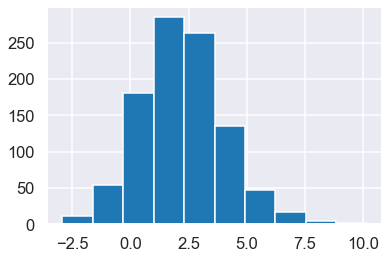

In [557]:
# Bootstrap sample 49 ppts and get diff in F-stat for each one

n = df_refexp['gameid'].nunique()
n_indices = list(range(0,n))
ppts = df_refexp['gameid'].unique()
nIters = 1000

r0_Fs = np.zeros(nIters)
r3_Fs = np.zeros(nIters)
r0_within_vars = np.zeros(nIters)
r3_within_vars = np.zeros(nIters)
r0_between_vars = np.zeros(nIters)
r3_between_vars = np.zeros(nIters)
F_differences = np.zeros(nIters)

r0_clustering_original = AffinityPropagation(random_state=0, damping=0.5).fit(r0_mat)
r3_clustering_original = AffinityPropagation(random_state=0, damping=0.5).fit(r3_mat)

seed = 0

for i in range(0,nIters): #1000 times
    
    seed += 1
#     rep1_random_state = seed # Use same sample across reps
#     rep3_random_state = seed # Use same sample across reps

#     # random clustering (before sampling ppts)
#     r0_clustering_original = AffinityPropagation(random_state=seed).fit(r0_mat)
#     r3_clustering_original = AffinityPropagation(random_state=seed).fit(r3_mat)

    np.random.seed(seed)
    ppt_sample = [np.random.choice(n_indices, ) for _ in n_indices]
    #ppt_sample = range(0, len(ppts))
    
    r0_new_labels = r0_clustering_original.labels_[ppt_sample]
    r3_new_labels = r3_clustering_original.labels_[ppt_sample]
    
    r0_Fs[i], r0_between_vars[i], r0_within_vars[i] = F_stat(r0_clustering, r0_mat[ppt_sample], labels = r0_new_labels, filter_n_1 = True)
    r3_Fs[i], r3_between_vars[i], r3_within_vars[i] = F_stat(r3_clustering, r3_mat[ppt_sample], labels = r3_new_labels, filter_n_1 = True)
    
#     r0_Fs[i] = r0_F
#     r3_Fs[i] = r3_F
#     r0_F[i] = F_stat(r0_clustering, r0_mat[ppt_sample], labels = r0_new_labels)
#     r3_F[i] = F_stat(r3_clustering, r3_mat[ppt_sample], labels = r3_new_labels)
    F_differences[i] = r3_Fs[i] - r0_Fs[i]
    
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep1_distances))
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep4_distances))

plt.hist(F_differences)


In [558]:
(sum(F_differences <0)/nIters)*2

0.186

It doesn't look like it gets much more clustery (i.e. groups that become more distinct from each other)

#### Try it with individual trials:

In [395]:
# Get word frequency distributions for all ppts
df_refexp_trial = df_refexp_unprocessed.groupby(['gameid','repNum','trialNum'])['content'].apply(lambda x: ' '.join(x)).reset_index()
df_refexp_trial['word_freq'] = df_refexp_trial['content'].apply(lambda x: Counter(x.split()))
df_refexp_trial


,gameid,repNum,trialNum,content,word_freq
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,two blue blocks two blue two red block two red...,"{'two': 6, 'blue': 4, 'blocks': 1, 'red': 6, '..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,two blue block two blue two red blocks two red...,"{'two': 6, 'blue': 6, 'block': 3, 'red': 4, 'b..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,blue block two red blue two red blue block blu...,"{'blue': 7, 'block': 4, 'two': 3, 'red': 5, 'o..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,3,same exact construction the same exact constru...,"{'same': 2, 'exact': 2, 'construction': 2, 'th..."
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,4,one blue block two red blocks blue two reds on...,"{'one': 2, 'blue': 6, 'block': 2, 'two': 6, 'r..."
...,...,...,...,...,...
583,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,7,a blue block blue a blue one blue two reds two...,"{'a': 3, 'blue': 8, 'block': 2, 'one': 1, 'two..."
584,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,8,a blue block blue two reds two reds blue blue ...,"{'a': 2, 'blue': 4, 'block': 1, 'two': 4, 'red..."
585,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,9,a blue blue two reds two reds a blue blue ablu...,"{'a': 3, 'blue': 7, 'two': 4, 'reds': 4, 'ablu..."
586,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,10,a red red the same same two blues two blues a ...,"{'a': 3, 'red': 2, 'the': 1, 'same': 2, 'two':..."


In [423]:
df_all_words_trial = df_refexp_trial[['gameid', 'repNum', 'trialNum' ,'content']]

for w in all_words:
    df_all_words_trial[w] = df_all_words_trial['content'].apply(lambda row: int(w in row.split()))


# df_all_words_trials = df_all_words_trial.groupby('repNum').agg(sum)
# r0_mat = np.array(df_all_words[df_all_words.repNum == 0].iloc[:,3:])
# r3_mat = np.array(df_all_words[df_all_words.repNum == 3].iloc[:,3:])

In [401]:
df_all_words_trial

,gameid,repNum,trialNum,content,two,blue,blocks,red,block,one,...,fifth,lock,beign,third,fourth,anoher,certicals,being,squares,ablue
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,two blue blocks two blue two red block two red...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,two blue block two blue two red blocks two red...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,blue block two red blue two red blue block blu...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,3,same exact construction the same exact constru...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,4,one blue block two red blocks blue two reds on...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,7,a blue block blue a blue one blue two reds two...,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
584,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,8,a blue block blue two reds two reds blue blue ...,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
585,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,9,a blue blue two reds two reds a blue blue ablu...,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
586,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,10,a red red the same same two blues two blues a ...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [404]:
r0_trial_mat = np.array(df_all_words_trial[df_all_words_trial.repNum == 0].iloc[:,4:])
r3_trial_mat = np.array(df_all_words_trial[df_all_words_trial.repNum == 3].iloc[:,4:])

In [481]:
# Slightly edited function from above that can deal with individual trials

def F_stat_trials(clustering, data, verbose = False, labels=[], filter_n_1 = True):
    
    
    if labels == []:
        labels = clustering.labels_
    
    label_counter = Counter(labels)
    
    if filter_n_1:
        data = data[list(map(lambda x: label_counter[x] > 1, labels))]
        labels = [label for label in labels if (label_counter[label] > 1)]
    
    n_clusters = len(set(labels))
    
    n_datapoints = len(data)
    
    overall_mean = np.mean(data, axis=0)
    
    total_within_variance = 0
    
    total_between_variance = 0
    

    for cluster_label in set(labels):

        # get rows of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_label)[0]]
        
        
        # calculate cluster mean
        cluster_mean = np.mean(cluster_members, axis=0)
        
        #print('mean: ' + str(cluster_mean))
        
        # between cluster
        cluster_squared_error = np.square(distance.euclidean(cluster_mean, overall_mean))
        between_cluster_value = (len(cluster_members)*cluster_squared_error)/(n_clusters-1)
        total_between_variance += between_cluster_value
        
        # Within cluster
        errors = np.apply_along_axis(lambda row: distance.euclidean(row, cluster_mean), 1, cluster_members)
        within_cluster_sum = np.sum(np.square(errors)/(n_datapoints-n_clusters))
        total_within_variance += within_cluster_sum
        
    return (total_between_variance/total_within_variance, total_between_variance, total_within_variance)


In [569]:
df_all_words_trial = df_refexp_trial[['gameid', 'repNum', 'trialNum' ,'content']]

for w in all_words:
    df_all_words_trial[w] = df_all_words_trial['content'].apply(lambda row: int(w in row.split()))

r0_clustering_original = AffinityPropagation(random_state=0, damping=0.5)\
    .fit(df_all_words_trial[df_all_words_trial.repNum == 0].iloc[:,4:])
r3_clustering_original = AffinityPropagation(random_state=0, damping=0.5)\
    .fit(df_all_words_trial[df_all_words_trial.repNum == 3].iloc[:,4:])

df_all_words_trial.loc[(df_all_words_trial.repNum == 0), 'r0_label'] = r0_clustering_original.labels_
df_all_words_trial.loc[(df_all_words_trial.repNum == 3), 'r3_label'] = r3_clustering_original.labels_
    

(array([  8.,  22., 120., 263., 288., 190.,  71.,  29.,   5.,   4.]),
 array([-3.43601277, -1.80960897, -0.18320517,  1.44319862,  3.06960242,
         4.69600622,  6.32241002,  7.94881382,  9.57521761, 11.20162141,
        12.82802521]),
 <a list of 10 Patch objects>)

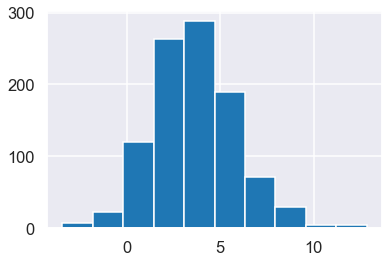

In [572]:
# Bootstrap sample 49 ppts and get diff in F-stat for each one

n = df_refexp['gameid'].nunique()
n_indices = list(range(0,n))
dyads = df_refexp['gameid'].unique()
nIters = 1000

r0_Fs = np.zeros(nIters)
r3_Fs = np.zeros(nIters)
r0_within_vars = np.zeros(nIters)
r3_within_vars = np.zeros(nIters)
r0_between_vars = np.zeros(nIters)
r3_between_vars = np.zeros(nIters)
F_differences = np.zeros(nIters)
    
seed = 0

for i in range(0,nIters): #1000 times
    
    seed += 1

    np.random.seed(seed)
    sample_indices = [np.random.choice(n_indices, ) for _ in n_indices]
    sample_dyads = dyads[sample_indices]
    
#     dyads = ppts[ppt_sample]
    
#     r0_trial_mat = np.array(df_all_words_trial[(df_all_words_trial.repNum == 0) \
#                                                & (df_all_words_trial.gameid in sample_dyads)].iloc[:,4:]).shape
#     r3_trial_mat = np.array(df_all_words_trial[df_all_words_trial.repNum == 3].iloc[:,4:]).shape
    
    # I need to index r0_trial_mat by the sample rows (I.e. all three trials from that rep)
    
    # we need to find the F-statistic of a sample of ppts, 
    # for this we will need a
    # a dataframe, consisting of rows from df_all_words_trial, all three for the rep for each participant each time that participant is sampled
    # a list of labels, corresponding to that row's cluster
    
    r0_sample_df = pd.concat([df_all_words_trial[(df_all_words_trial.repNum == 0) & (df_all_words_trial.gameid == gameid)]\
                                   for gameid in sample_dyads])
    
    r3_sample_df = pd.concat([df_all_words_trial[(df_all_words_trial.repNum == 3) & (df_all_words_trial.gameid == gameid)]\
                                   for gameid in sample_dyads])
    
    # grab labels
    r0_new_labels = np.array(r0_sample_df.loc[:,'r0_label'].astype(int))
    r3_new_labels = np.array(r3_sample_df.loc[:,'r3_label'].astype(int))
    
    # just grab words
    r0_sample_df_data = np.array(r0_sample_df.loc[:,'two':'ablue'])
    r3_sample_df_data = np.array(r3_sample_df.loc[:,'two':'ablue'])
    
#     r0_new_labels = r0_clustering_original.labels_[ppt_sample]
#     r3_new_labels = r3_clustering_original.labels_[ppt_sample]
    
    r0_Fs[i], r0_between_vars[i], r0_within_vars[i] = F_stat_trials(r0_clustering_original, r0_sample_df_data, labels = r0_new_labels, filter_n_1 = False)
    r3_Fs[i], r3_between_vars[i], r3_within_vars[i] = F_stat_trials(r3_clustering_original, r3_sample_df_data, labels = r3_new_labels, filter_n_1 = False)
    
#     r0_Fs[i] = r0_F
#     r3_Fs[i] = r3_F
#     r0_F[i] = F_stat(r0_clustering, r0_mat[ppt_sample], labels = r0_new_labels)
#     r3_F[i] = F_stat(r3_clustering, r3_mat[ppt_sample], labels = r3_new_labels)
    F_differences[i] = r3_Fs[i] - r0_Fs[i]
    
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep1_distances))
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep4_distances))

plt.hist(F_differences)


In [573]:
(sum(F_differences < 0)/nIters)*2

0.074

This does appear more clustery, but only when we include clusters only one member, which brings up the F statistic

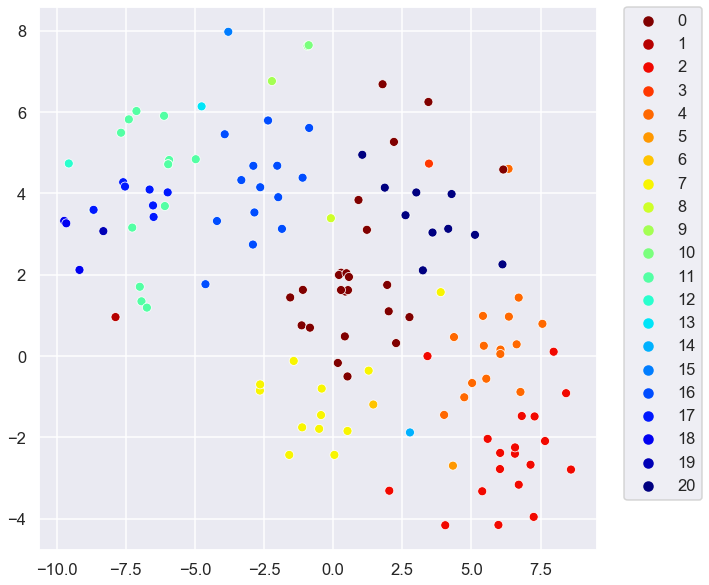

In [682]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

tsne = TSNE()
X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 0)].loc[:,'two':'ablue'])
cluster_labels = r0_clustering_original.labels_

plt.figure(figsize=(10,10))

palette = sns.color_palette("bright", len(cluster_labels))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cluster_labels, legend='full', palette='jet_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [571]:
Counter(r0_clustering_original.labels_).most_common()

[(0, 31),
 (2, 20),
 (16, 17),
 (4, 16),
 (11, 14),
 (20, 14),
 (7, 12),
 (17, 7),
 (18, 3),
 (10, 2),
 (1, 1),
 (3, 1),
 (5, 1),
 (6, 1),
 (8, 1),
 (9, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (19, 1)]

In [622]:
cluster_number = 7

df_refexp_trial[df_refexp_trial.repNum==0].iloc[np.where(r0_clustering_original.labels_== cluster_number)[0],3]

156    blue 2 reds blue 2 reds blue block elongated "...
336    2 blue blocks 2 red blocks 2 blue blocks 2 red...
337    2 blue 2 red 2 blue 2 red 2 blue upside down u...
338    left blue 2 reds another blue 2 reds another b...
361    2blues two reds 2 blue two reds blue two reds ...
362    blue blue 2 reds blue blue 2reds red red blue ...
470    blue blk 2 rds blue blue 2reds blue upsidedown...
481    1 red 1 red blue table 1 red 1red blue table 1...
504    blue 2 red ones one blue one blue 2reds one bl...
516    red blue blue 2 reds blu red blue blue 2reds 2...
517    blues blu 2reds blue blue 2reds 2 blu rds blue...
518          2 blues 2 reds red blue roof 2 blues 2 reds
Name: content, dtype: object

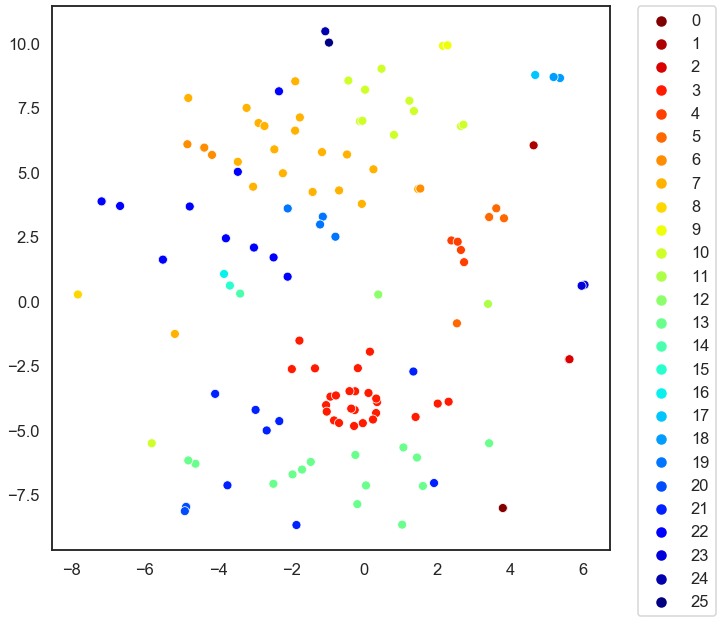

In [735]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

tsne = TSNE()
X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
cluster_labels = r3_clustering_original.labels_


plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cluster_labels, legend='full', palette='jet_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [570]:
Counter(r3_clustering_original.labels_).most_common()

[(3, 25),
 (7, 24),
 (22, 15),
 (13, 15),
 (10, 12),
 (21, 9),
 (5, 6),
 (19, 5),
 (6, 5),
 (4, 4),
 (8, 3),
 (20, 3),
 (23, 3),
 (0, 2),
 (2, 2),
 (9, 2),
 (12, 2),
 (18, 2),
 (1, 1),
 (11, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (24, 1),
 (25, 1)]

In [756]:
cluster_number = 24

df_refexp_trial[df_refexp_trial.repNum==3].iloc[np.where(r3_clustering_original.labels_== cluster_number)[0],3]

573    another house shape certicals second and fifth...
Name: content, dtype: object

In [ ]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

tsne = TSNE()

r0_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 0)].loc[:,'two':'ablue'])
r0_cluster_labels = r0_clustering_original.labels_

r3_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
r3_cluster_labels = r3_clustering_original.labels_



plt.figure(figsize=(16,10))

for i, x in enumerate(r0_X_embedded[:,0]):
    plt.plot([x,r3_X_embedded[i,0]], [r0_X_embedded[i,1],r3_X_embedded[i,1]], color = (0,0,0,0.3) )

palette = sns.color_palette("bright", len(cluster_labels))
sns.scatterplot(r0_X_embedded[:,0], r0_X_embedded[:,1], hue=r3_X_embedded[:,1], legend='full', palette='Blues', size=50)
sns.scatterplot(r3_X_embedded[:,0], r3_X_embedded[:,1], hue=r3_X_embedded[:,1], legend='full', palette='Greens', size=100)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

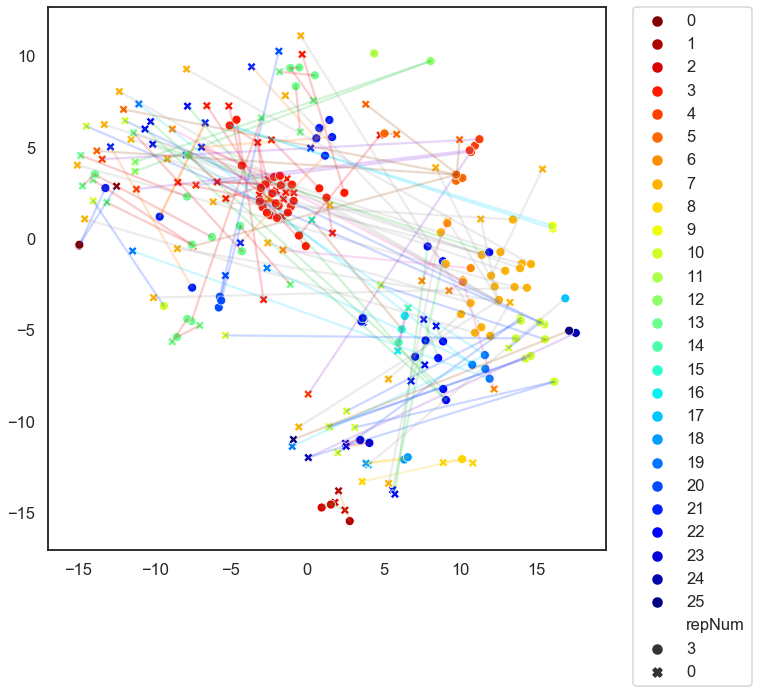

In [742]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

np.random.seed(2)
tsne = TSNE()

X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 0)].loc[:,'two':'ablue'].append(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue']))
cluster_labels = np.concatenate((r3_clustering_original.labels_,r3_clustering_original.labels_)) # both reps colored by final cluster assignment

# r3_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
# r3_cluster_labels = r3_clustering_original.labels_

plt.figure(figsize=(10,10))

repNums = df_all_words_trial[(df_all_words_trial.repNum == 0)].append(df_all_words_trial[(df_all_words_trial.repNum == 3)]).repNum

palette = sns.color_palette("bright", len(set(cluster_labels)))

n = int(len(X_embedded[:,0])/2)

for i, x in enumerate(X_embedded[:n,0]):
    # plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = (0,0,0,0.05), palette=palette)
    # set color to be that of final rep
    plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.2)

# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cluster_labels, legend='full', palette=[(0.1,0.2,0.4),(0.4,0.8,0.4)], alpha=1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cluster_labels, legend='full', palette='jet_r', style=repNums, style_order=[3,0], alpha=1)

# sns.scatterplot(r3_X_embedded[:,0], r3_X_embedded[:,1], hue=r3_X_embedded[:,1], legend='full', palette='Greens', size=100)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

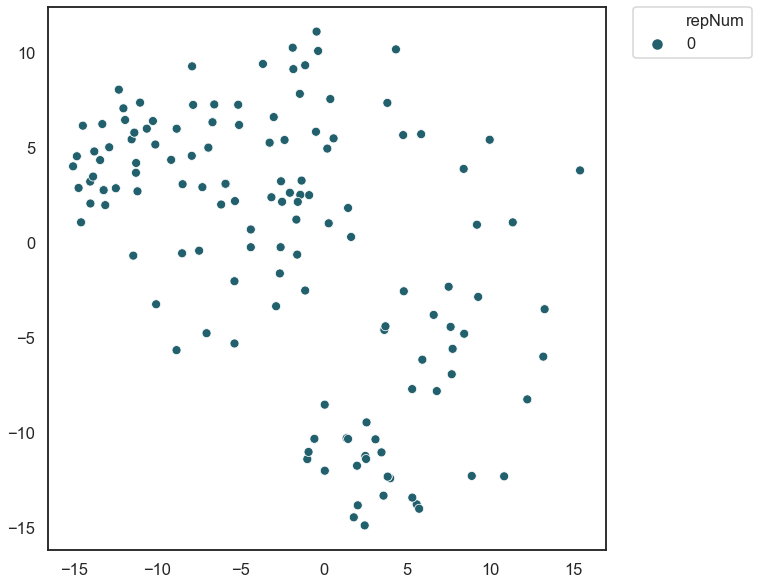

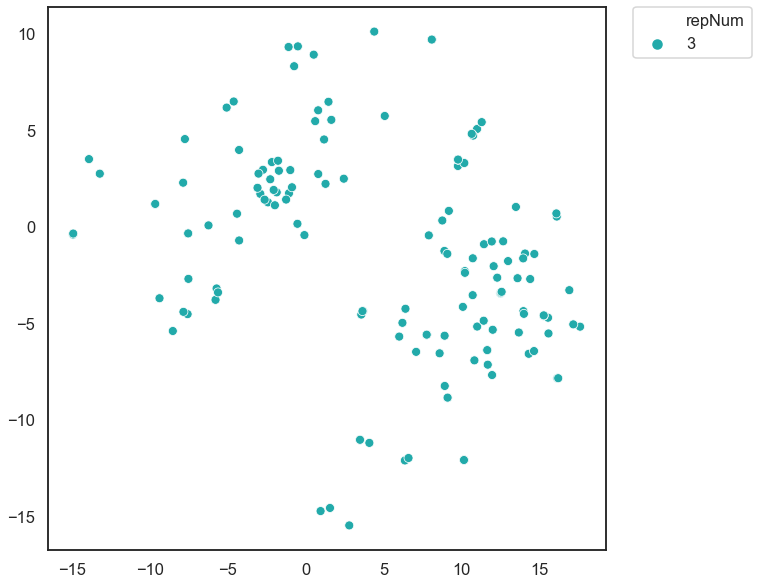

In [692]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

np.random.seed(2)
tsne = TSNE()

X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 0)].loc[:,'two':'ablue'].append(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue']))
cluster_labels = r0_clustering_original.labels_ + r3_clustering_original.labels_
#cluster_labels = np.concatenate((r3_clustering_original.labels_,r3_clustering_original.labels_)) # both reps colored by final cluster assignment

# r3_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
# r3_cluster_labels = r3_clustering_original.labels_

colors = df_all_words_trial[(df_all_words_trial.repNum == 0)].append(df_all_words_trial[(df_all_words_trial.repNum == 3)]).repNum

n = int(len(X_embedded[:,0])/2)

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = (0,0,0,0.05) )

sns.set_style('white')

plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:n,0], X_embedded[:n,1], hue=colors[0:n], legend='full', palette=['#21606C'], alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[n:,0], X_embedded[n:,1], hue=colors[n:], legend='full', palette=['#22AAAA'], alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [770]:
[(Counter(cluster_labels[n:])[x] == 1) for x in set(cluster_labels)]

[False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True]

In [865]:
[(Counter(cluster_labels[n:])[x] == 3) for x in set(cluster_labels)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False]

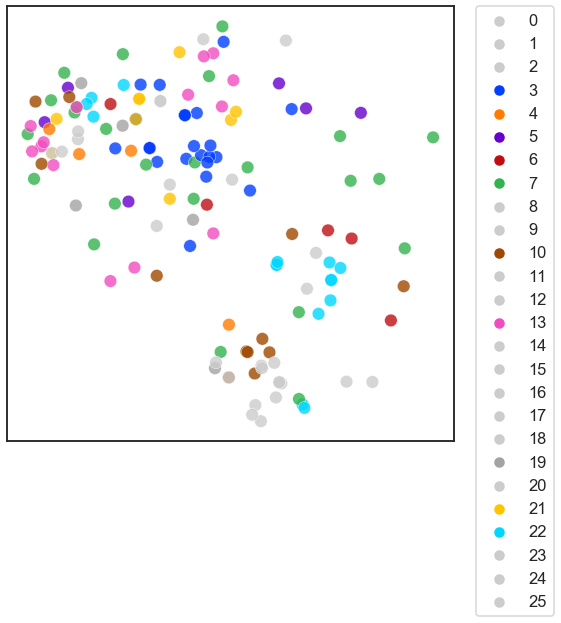

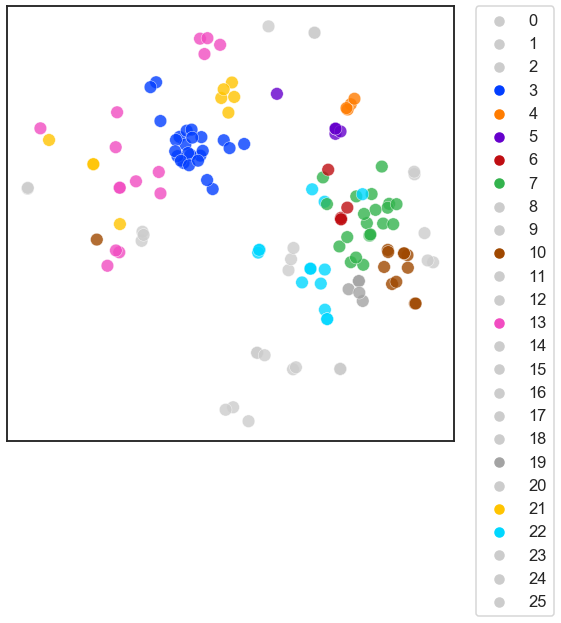

In [898]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

np.random.seed(2)
tsne = TSNE()

X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 0)].loc[:,'two':'ablue'].append(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue']))
#cluster_labels = r0_clustering_original.labels_ + r3_clustering_original.labels_
cluster_labels = np.concatenate((r3_clustering_original.labels_,r3_clustering_original.labels_)) # both reps colored by final cluster assignment

# r3_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
# r3_cluster_labels = r3_clustering_original.labels_

colors = df_all_words_trial[(df_all_words_trial.repNum == 0)].append(df_all_words_trial[(df_all_words_trial.repNum == 3)]).repNum

n = int(len(X_embedded[:,0])/2)

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = (0,0,0,0.05) )

palette = np.array(sns.color_palette("jet_r", len(set(cluster_labels))))

palette[[(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]] = (0.8,0.8,0.8)

palette[[(Counter(cluster_labels[n:])[x] > 3) for x in set(cluster_labels)]] = sns.color_palette("bright", len(set(cluster_labels)) - sum([(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]))

palette = list(palette)

palette[5] = ([0.4,0.0,0.8])

palette[6] = ([0.75,0.05,0.07])

palette[7] = ([0.2,0.7,0.3])

sns.set_style('white')

plt.figure(figsize=(8,8))
sns.scatterplot(X_embedded[:n,0], X_embedded[:n,1], hue=cluster_labels[0:n], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.figure(figsize=(8,8))

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.1)

sns.scatterplot(X_embedded[n:,0], X_embedded[n:,1], hue=cluster_labels[n:], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)

# plt.savefig('../results/plots/rep4_clusters.pdf')


In [864]:
cluster_number = 21

df_refexp_trial[df_refexp_trial.repNum==3].iloc[np.where(r3_clustering_original.labels_== cluster_number)[0],3].apply(lambda x: set(x.split()))


9                 {block, red, two, blocks, one, blue}
142              {final, "l", red, two, reds, l, blue}
213            {1, two, 2, same, l, reds, shape, blue}
513                             {red, blue, two, reds}
514             {8-9, two, reds, at, 10-11, blue, and}
515               {8-910-11, red, two, reds, at, blue}
585                        {a, two, reds, ablue, blue}
586        {the, blues, a, red, two, same, reds, blue}
587    {blues, a, red, two, same, reds, blue, another}
Name: content, dtype: object

### Explore differences when ignoring clusters of 1

In [355]:
r0_within_vars_old = r0_within_vars.copy()
r3_within_vars_old = r3_within_vars.copy()
r0_between_vars_old = r0_between_vars.copy()
r3_between_vars_old = r3_between_vars.copy()


(array([ 82., 207., 280., 230., 116.,  52.,  20.,   8.,   3.,   2.]),
 array([-0.02854868,  1.26399877,  2.55654622,  3.84909367,  5.14164112,
         6.43418857,  7.72673603,  9.01928348, 10.31183093, 11.60437838,
        12.89692583]),
 <a list of 10 Patch objects>)

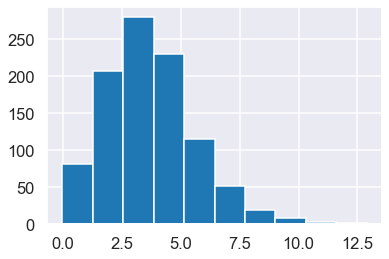

In [386]:
plt.hist(r3_between_vars - r3_between_vars_old)

(array([ 62., 182., 288., 259., 141.,  47.,  17.,   3.,   0.,   1.]),
 array([ 0.        ,  1.57891649,  3.15783297,  4.73674946,  6.31566595,
         7.89458243,  9.47349892, 11.05241541, 12.6313319 , 14.21024838,
        15.78916487]),
 <a list of 10 Patch objects>)

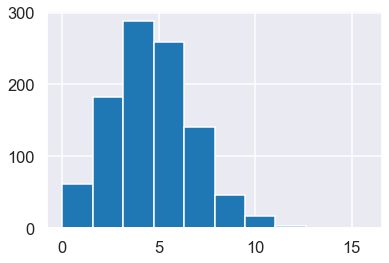

In [385]:
plt.hist(r0_between_vars- r0_between_vars_old)

(array([  1.,   0.,  19.,   0.,   0., 957.,   0.,  21.,   0.,   2.]),
 array([-8.88178420e-16, -7.10542736e-16, -5.32907052e-16, -3.55271368e-16,
        -1.77635684e-16,  0.00000000e+00,  1.77635684e-16,  3.55271368e-16,
         5.32907052e-16,  7.10542736e-16,  8.88178420e-16]),
 <a list of 10 Patch objects>)

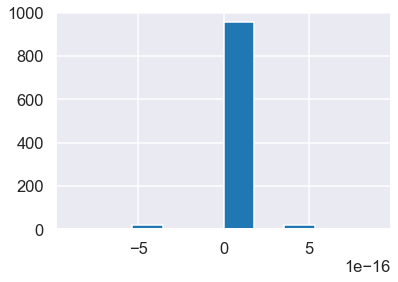

In [384]:
plt.hist(r3_within_vars_old - r3_within_vars)

In [364]:
r3_between_vars

array([20.93373016, 32.84656028, 22.7928487 , 23.29368457, 22.55533597,
       25.70139438, 26.53874142, 23.22712862, 26.12256839, 22.92577348,
       21.09445826, 24.61022727, 23.17792159, 22.20018116, 23.27968509,
       23.93478261, 20.82269022, 22.91534392, 23.3695331 , 19.08724762,
       23.21961948, 24.76174242, 25.94693276, 27.22371985, 26.49166667,
       27.09856209, 24.48301169, 22.73416667, 23.82850077, 21.7031198 ,
       27.28213652, 21.33808081, 21.76060671, 23.75968661, 22.77083333,
       25.83125   , 26.58106061, 28.95119565, 24.11458333, 23.30512293,
       23.17462927, 19.59165569, 27.96548286, 24.17873952, 26.57323591,
       24.97653289, 22.08962418, 22.75460317, 24.71583482, 24.84984336,
       23.58599998, 24.0278513 , 25.85643116, 20.16111111, 19.51076389,
       21.3134058 , 22.25477124, 30.5782197 , 24.59917717, 23.83931159,
       26.5003885 , 26.33051672, 19.12716574, 22.55985507, 21.78265993,
       21.02447552, 29.19037487, 18.69750712, 25.49309724, 23.77

(array([  3.,  14.,  35.,  64., 189., 248., 260., 134.,  44.,   9.]),
 array([-26.42816845, -23.35836745, -20.28856645, -17.21876545,
        -14.14896444, -11.07916344,  -8.00936244,  -4.93956144,
         -1.86976044,   1.20004056,   4.26984156]),
 <a list of 10 Patch objects>)

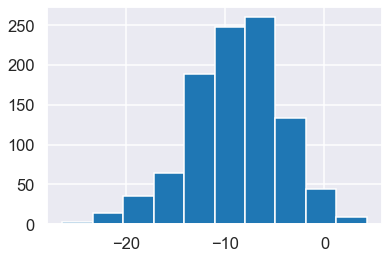

In [338]:
plt.hist(r3_between_vars - r0_between_vars)

(array([  5.,  13.,  44., 126., 242., 244., 190.,  86.,  43.,   7.]),
 array([-4.46281928, -4.09632174, -3.72982421, -3.36332667, -2.99682913,
        -2.6303316 , -2.26383406, -1.89733653, -1.53083899, -1.16434146,
        -0.79784392]),
 <a list of 10 Patch objects>)

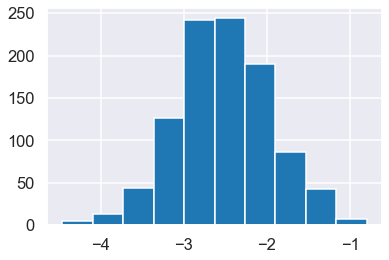

In [339]:
plt.hist(r3_within_vars - r0_within_vars)

In [253]:
# between-group variability

# sample mean of ith group

def F_stat(clustering, data, verbose = False, labels=[] ):

    if labels == []:
        labels = clustering.labels_
    
    n_clusters = len(set(labels))
    n_datapoints = len(data)
    
    overall_mean = np.mean(data, axis=0)
    
    total_within_variance = 0
    
    total_between_variance = 0
    

    for cluster_label in set(labels):

        # get rows of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_label)[0]]
        
#         print('cluster_label: ' + str(cluster_label))
#         print('cluster_members: ' + str(len(cluster_members)))
        
        # calculate cluster mean
        cluster_mean = np.mean(cluster_members, axis=0)
        #print('mean: ' + str(cluster_mean))
        
        # between cluster
        cluster_squared_error = np.square(distance.euclidean(cluster_mean, overall_mean))
        between_cluster_value = (len(cluster_members)*cluster_squared_error)/(n_clusters-1)
        total_between_variance += between_cluster_value
        
        # Within cluster
        errors = np.apply_along_axis(lambda row: distance.euclidean(row, cluster_mean), 1, cluster_members)
        within_cluster_sum = np.sum(np.square(errors)/(n_datapoints-n_clusters))
        total_within_variance += within_cluster_sum
        
    return total_between_variance/total_within_variance


In [227]:

def get_pairwise_within_cluster_distances(clustering, data, verbose = False):
    
    distances = []
    
    labels = clustering.labels_
    
    exemplars = data[clustering.cluster_centers_indices_]

    n_clusters = len(exemplars)
    
    cluster_dists = []

    for cluster_number in range(len(exemplars)):
        
        # get indices of all ppts for that cluster
        cluster_members = data[np.where(labels==cluster_number)[0]]
        
        within_cluster_dists = np.zeros((len(cluster_members),len(cluster_members)))
        
        for i, d1 in enumerate(cluster_members):
            for j, d2 in enumerate(cluster_members):
                within_cluster_dists[i, j] = distance.euclidean(d1, d2)
        
        print(str(cluster_number) + str(within_cluster_dists))
        
        if len(within_cluster_dists) > 1:
            cluster_dists
        

    return distances

In [ ]:
r0_within = get_pairwise_within_cluster_distances(r0_clustering, r0_mat)

In [ ]:
np.where(r0_labels==2)[0]

In [ ]:
np.where(r0_labels==1)

In [ ]:
r0_within = get_within_cluster_distances(r0_clustering, r0_mat)
r3_within = get_within_cluster_distances(r3_clustering, r3_mat)

In [ ]:
print('distance between each ppt and its exemplar')
print('rep 0 mean: ' + str(np.mean(r0_within)))
print('rep 0  std: ' + str(np.std(r0_within)))
print('rep 3 mean: ' + str(np.mean(r3_within)))
print('rep 3  std: ' + str(np.std(r3_within)))

In [ ]:
r0_between = get_within_cluster_distances(r0_clustering, r0_mat)
r3_between = get_within_cluster_distances(r3_clustering, r3_mat)

In [ ]:
print('distances between all exemplars')
print('rep 0 mean: ' + str(np.mean(np.triu(r0_within))))
print('rep 0  std: ' + str(np.std(np.triu(r0_within))))
print('rep 3 mean: ' + str(np.mean(np.triu(r3_within))))
print('rep 3  std: ' + str(np.std(np.triu(r3_within))))

In [251]:
# variance between clusters, rep 0

r0_n_clusters = len(r0_clustering.cluster_centers_indices_)

r0_sum_sq_diffs = np.sum(np.square(np.triu(r0_within)))
r0_var_between = r0_sum_sq_diffs/(r0_n_clusters**2)
print('rep 0 variance: ' + str(r0_var_between))

# variance between clusters, rep 1

r3_n_clusters = len(r3_clustering.cluster_centers_indices_)

r3_sum_sq_diffs = np.sum(np.square(np.triu(r3_within)))
r3_var_between = r3_sum_sq_diffs/(r3_n_clusters**2)
print('rep 3 variance: ' + str(r3_var_between))

NameError: name 'r0_within' is not defined

In [ ]:
# F-test- not sure what to do with these

r0_F = r0_var_between/np.var(r0_within)

r3_F = r3_var_between/np.var(r3_within)

In [ ]:
np.array([rep_0_clustering.labels_, rep_3_clustering.labels_]).transpose()

In [ ]:
np.array([rep_0_clustering.cluster_centers_indices_, rep_3_clustering.cluster_centers_indices_]).transpose()

In [ ]:
# from itertools import cycle

# plt.close('all')
# plt.figure(1)
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(r0_n_clusters_), colors):
#     class_members = r0_labels == k
#     cluster_center = r0_mat[r0_cluster_centers_indices[k]]
#     plt.plot(r0_mat[class_members, 0], r0_mat[class_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
#     for x in r0_mat[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# plt.title('Estimated number of clusters: %d' % r0_n_clusters_)
# plt.show()

In [249]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

tsne = TSNE()
X_embedded = tsne.fit_transform(r0_mat)

palette = sns.color_palette("bright", r0_n_clusters)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=rep_0_clustering.labels_, legend='full', palette=palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

NameError: name 'r0_n_clusters' is not defined

In [250]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

tsne = TSNE()
X_embedded = tsne.fit_transform(r3_mat)

palette = sns.color_palette("bright", r3_n_clusters)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=rep_3_clustering.labels_, legend='full', palette=palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

NameError: name 'r3_n_clusters' is not defined

In [843]:
cluster_number = 2

df_refexp[df_refexp.repNum==0].iloc[np.where(r0_clustering.labels_== cluster_number)[0],2]

0      two blue blocks two blue two red block two red...
4      blue blue blue blue blue blue red red red red ...
8      two blocks placed horizontally two blocks 2 bl...
12     blue block blue 2 red bocks 2 red blue block b...
44     blue blue red red block red red blue "c" blue ...
48     1 blue domino 2 two red dominos 3 blue blue tw...
68     2 blue blocks 1 blue block 2 blue 1 blue two r...
88     blue blue blue blue red another red red red an...
92     two blue blocks two blue blocks 4 blocks 1 blu...
104    blue lay 1more red 4 blue red 2 blue total 4 r...
108    blue block blue red red red blue red blue red ...
140    horizontal block horizontal horizontal block h...
156    2blks 4 vert.blks 2blks on ea. side horiz 4 ve...
160    2 blue 2 blue 2 red 2 red a red 1 more red red...
172    red blue blue 2 reds blu red blue blue 2reds 2...
180    horizontal horizontal vertical vertical anothe...
Name: content, dtype: object

In [ ]:
Counter(rep_0_clustering.labels_)

In [ ]:
Counter(rep_3_clustering.labels_)

In [ ]:
r0_clustering.labels_

In [ ]:
np.where(r0_clustering.labels_== 2)[0]